<div class="usecase-title">Pedestrian Prediction</div>

<div class="usecase-authors"><b>Authored by: </b> Thomas Rostov</div>

<div class="usecase-duration"><b>Duration:</b> 120 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Advanced</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, Pandas, Matplotlib, scikit-learn</div>
</div>

<div class="usecase-section-header">Scenario</div>

From a city planners perspective: I would like to analyze pedestrian movements based on factors such as time and weather to improve infrastructure/pedestrian safety and plan for events.

From a residents perspective: I would like to see pedestrian foot traffic patterns out of general interest and potentially to help with business planning. 

<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:
- Learn how to clean data and combine dataframes.
- Use matplotlib to visualize pedestrian movement patterns. 
- Use regression machine learning models to predict pedestrian patterns based on time and weather. 
- Analyse regression model performance using metrics and visualisations.
- Work with a mix of categorical and continuous data.  
- Create a list of models to perform predictions based on the entire dataset.
- Create a composite model using encoding to also perform predictions using the entire dataset.
- Visualise these predictions on an interactive map. 

<div class="usecase-section-header">Introduction</div>

This project will focus on finding pedestrian movement patterns based on data collected by the City of Melbourne. The first dataset involves data collected by multiple sensors placed around city streets. These sensors detect when people move past them, with hourly totals dating over a year back. The second dataset involves data collected by weather sensors, which detect both the temperature and humidity at the time of recording. By matching the weather data with the pedestrian data, we can analyse how both time, temperature and humidity influence pedestrian movement. Visualisations and machine learning models will be made to both visualize and predict these patterns in movement. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import ipywidgets as widgets
import requests
import folium
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

## Importing Datasets

Use this if importing with API, comment this out if importing downloaded datasets

In [2]:
def collect_data(dataset_id):
    base_url = "https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/"
    apikey = apikey
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC',
        'api_key': apikey  # use if use datasets API_key permissions
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        print(f'Request failed with status code {response.status_code}')
        
data = collect_data('pedestrian-counting-system-monthly-counts-per-hour')
data_sensor = collect_data('meshed-sensor-type-2')

Use this if importing downloaded datasets, comment this cell out if importing with API

In [3]:
# data = pd.read_csv("pedcount.csv")
# data_sensor = pd.read_csv("sensorreadings.csv")

## Dataset Cleaning and Merging

Visualising the shape and first 5 rows of the imported datasets (as dataframes) that will be worked with. 

The data dataframe contains pedestrian data, while the data_sensor dataframe contains weather information.

In [4]:
# Renaming columns to match downloaded/website view data format, comment out if using locally downloaded dataset. 
data.rename(columns={'sensor_name': 'Sensor_Name', 'timestamp': 'SensingDateTime(Hour)', 'locationid': 'LocationID', 
                   'direction_1': 'Direction_1', 'direction_2': 'Direction_2', 'total_of_directions': 'Total_of_Directions', 
                   'location': 'Location'}, inplace=True)

print(data.shape)
data.head()

(549976, 7)


,Sensor_Name,SensingDateTime(Hour),LocationID,Direction_1,Direction_2,Total_of_Directions,Location
0,Fra118_T,2023-06-06T03:00:00+10:00,51,1,4,5,"-37.80841815, 144.95906316"
1,Fra118_T,2023-06-06T04:00:00+10:00,51,7,5,12,"-37.80841815, 144.95906316"
2,Fra118_T,2023-06-06T06:00:00+10:00,51,10,22,32,"-37.80841815, 144.95906316"
3,Fra118_T,2023-06-06T11:00:00+10:00,51,94,136,230,"-37.80841815, 144.95906316"
4,Fra118_T,2023-06-06T12:00:00+10:00,51,166,126,292,"-37.80841815, 144.95906316"


In [5]:
# Renaming columns, comment out if using locally downloaded dataset. 
data_sensor.rename(columns={'sensor_name': 'Sensor Name', 'lat_long': 'Lat Long', 
                            'location_picture_hyperlink': 'Location Picture Hyperlink'}, inplace=True)

print(data_sensor.shape)
data_sensor.head()

(31362, 8)


,time,dev_id,Sensor Name,temperature,humidity,battery,Lat Long,Location Picture Hyperlink
0,2023-02-26T14:37:18+11:00,r712-a7f7,Bench Hub,24.11,55.94,3,"-37.8030396, 144.965898",https://melbournetestbed.opendatasoft.com/asse...
1,2023-02-26T15:33:38+11:00,r712-a7f8,Elm,20.98,65.33,3,"-37.8027955, 144.9657785",https://melbournetestbed.opendatasoft.com/asse...
2,2023-02-26T15:37:32+11:00,r712-a7f7,Bench Hub,21.29,63.02,3,"-37.8030396, 144.965898",https://melbournetestbed.opendatasoft.com/asse...
3,2023-02-26T17:33:39+11:00,r712-a7f8,Elm,19.75,76.39,3,"-37.8027955, 144.9657785",https://melbournetestbed.opendatasoft.com/asse...
4,2023-02-26T17:37:19+11:00,r712-a7f7,Bench Hub,20.08,73.95,3,"-37.8030396, 144.965898",https://melbournetestbed.opendatasoft.com/asse...


Convert date/time data to python datetime objects and remove the timezone in both dataframes.

In [6]:
data['datetime'] = pd.to_datetime(data['SensingDateTime(Hour)'], errors='coerce') 
data_sensor['datetime'] = pd.to_datetime(data_sensor['time'], errors='coerce') 

def remove_timezone(x):
     return x.replace(tzinfo=None)
    
data['datetime_no_tz'] = data['datetime'].apply(remove_timezone)
data_sensor['datetime_no_tz_unrounded'] = data_sensor['datetime'].apply(remove_timezone)

Round down the time values in the sensor dataframe to the nearest hour, to match the pedestrian dataframes format. Average the values from the different sensors at a specific hour, so that each hour has a single temperature and humidity reading.

In [7]:
def round_down(dt):
    if dt.minute > 0 or dt.second > 0:
        dt -= datetime.timedelta(minutes=dt.minute, seconds=dt.second, microseconds=dt.microsecond)
    return dt

data_sensor['datetime_no_tz'] = data_sensor['datetime_no_tz_unrounded'].apply(round_down)

data_sensor_mean = data_sensor.groupby('datetime_no_tz').agg({'temperature': 'mean', 'humidity': 'mean'}).reset_index()

Merge the dataframes based on the hour, so that each hour has a unique weather and pedestrian count reading. Show the datetime in a unique datetime column. Make a new column for the day of the week (1 = Monday, 2 = Tuesday etc), and another for months following the same format. Remove all NA values.

In [8]:
df_merged = pd.merge(data, data_sensor_mean[['datetime_no_tz', 'temperature', 'humidity']], on='datetime_no_tz', how='left')
df_merged['hour'] = df_merged['datetime_no_tz'].dt.time
df_merged.drop(columns=['SensingDateTime(Hour)','datetime'], inplace=True)
df_merged.rename(columns={'datetime_no_tz': 'datetime'}, inplace=True)
df_merged['day_of_week'] = df_merged['datetime'].dt.day_of_week + 1
df_merged['month'] = df_merged['datetime'].dt.month
df_merged = df_merged.dropna()

Dropping all sensors that have less than 5k values to ensure each sensor has enough data to work with.

In [9]:
sensor_counts = df_merged['Sensor_Name'].value_counts()
sensors_to_keep = sensor_counts[sensor_counts >= 5000].index.tolist()
df_merged = df_merged[df_merged['Sensor_Name'].isin(sensors_to_keep)]

Removing extreme outliers for each sensor.

In [10]:
def remove_outliers(sensor):
    q1 = sensor['Total_of_Directions'].quantile(0.25)
    q3 = sensor['Total_of_Directions'].quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 4 * iqr
    return sensor[(sensor['Total_of_Directions'] <= upper_bound)]

df_merged = df_merged.groupby('Sensor_Name').apply(remove_outliers).reset_index(drop=True)

Visualising the resultant composite dataframe after the above steps have been applied .

In [11]:
print(df_merged.shape)
df_merged.head()

(490544, 12)


,Sensor_Name,LocationID,Direction_1,Direction_2,Total_of_Directions,Location,datetime,temperature,humidity,hour,day_of_week,month
0,261Will_T,108,47,295,342,"-37.81295822, 144.95678789",2023-06-06 06:00:00,17.006667,73.813333,06:00:00,2,6
1,261Will_T,108,75,699,774,"-37.81295822, 144.95678789",2023-06-06 07:00:00,17.393333,72.800000,07:00:00,2,6
2,261Will_T,108,291,909,1200,"-37.81295822, 144.95678789",2023-06-06 09:00:00,17.847500,73.305000,09:00:00,2,6
3,261Will_T,108,282,275,557,"-37.81295822, 144.95678789",2023-06-06 11:00:00,18.130000,73.372500,11:00:00,2,6
4,261Will_T,108,484,190,674,"-37.81295822, 144.95678789",2023-06-06 15:00:00,20.505000,65.530000,15:00:00,2,6


## Number of pedestrians based on time, temperature and humidity

Creates a plot using string inputs for weather of 'temperature' or 'humidity', and the time (hour), format: '1:00:00'.

In [12]:
def update_plot(weather, hour):
    df_hourly = df_merged[(df_merged['hour'] == pd.to_datetime(hour).time())]
    
    filtered_df = df_hourly
    
    df_agg = filtered_df.groupby(weather)['Total_of_Directions'].sum().reset_index()
    
    plt.figure(figsize=(10, 6))  
    plt.scatter(df_agg[weather], df_agg['Total_of_Directions'])  
    plt.title('Number Of Pedestrians vs. Temp/Humidity')  
    plt.xlabel('Temp/Humidity')  
    plt.ylabel('Total Directions')  
    plt.grid(True) 
    plt.show()

Widget dropdown menu, to select humidity/temperature and hour.

In [13]:
dropdown_weather = widgets.Dropdown(
    options=['humidity', 'temperature'],
    value='temperature',
    description='Temp/Hum:',
    disabled=False,
)

dropdown_time = widgets.Dropdown(
    options=['1:00:00', '2:00:00', '3:00:00', '4:00:00', '5:00:00', '6:00:00', '7:00:00', '8:00:00', '9:00:00', 
             '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00', '18:00:00', 
             '19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00', '24:00:00'], 
    value='12:00:00',
    description='Time:',
    disabled=False,
)

Create button widgets and display them, allowing for the selection of time and weather variables.

In [14]:
def on_button_click(a):
    update_plot(dropdown_weather.value, dropdown_time.value)

button = widgets.Button(description="Create Graph")
button.on_click(on_button_click)

display(widgets.HBox([dropdown_weather, dropdown_time]))
display(button)

Button(description='Create Graph', style=ButtonStyle())

## Visualize Median Pedestrian Traffic Based On Time and Day of Week

Visualizing median pedestrian foot traffic by hour, grouping by hour and finding the median

In [15]:
df_ped_median = df_merged.groupby('hour').agg({'Total_of_Directions': 'median'})

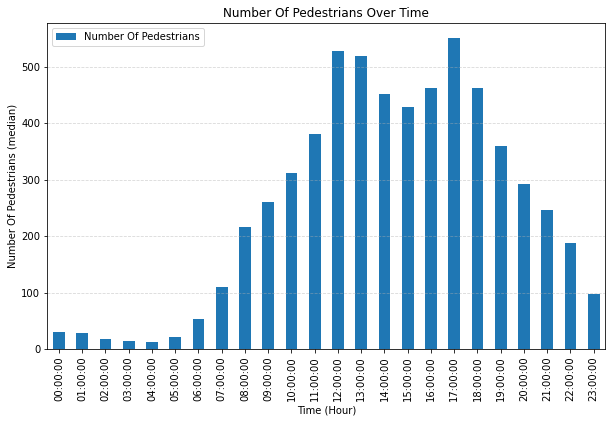

In [16]:
ax = df_ped_median.plot(kind='bar', figsize=(10, 6))

ax.set_title('Number Of Pedestrians Over Time')
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('Number Of Pedestrians (median)')
ax.legend(['Number Of Pedestrians'])
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

Visualizing median pedestrian foot traffic by the day of the week, grouping by day and finding the median

In [17]:
df_ped_median_d = df_merged.groupby('day_of_week').agg({'Total_of_Directions': 'median'})

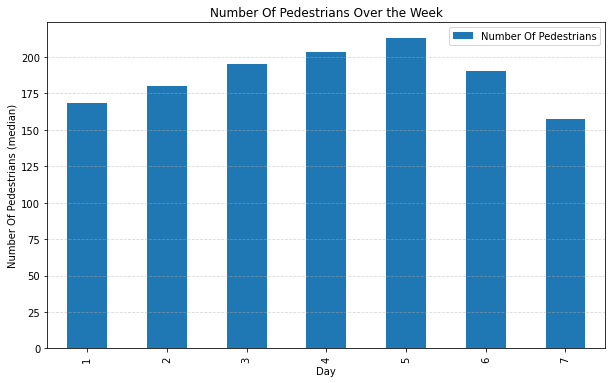

In [18]:
ax = df_ped_median_d.plot(kind='bar', y='Total_of_Directions', figsize=(10, 6))

ax.set_title('Number Of Pedestrians Over the Week')
ax.set_xlabel('Day')
ax.set_ylabel('Number Of Pedestrians (median)')
ax.legend(['Number Of Pedestrians'])
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

Visualizing median pedestrian foot traffic by month of the year, grouping by month and finding the median

In [19]:
df_ped_median_m = df_merged.groupby('month').agg({'Total_of_Directions': 'median'})

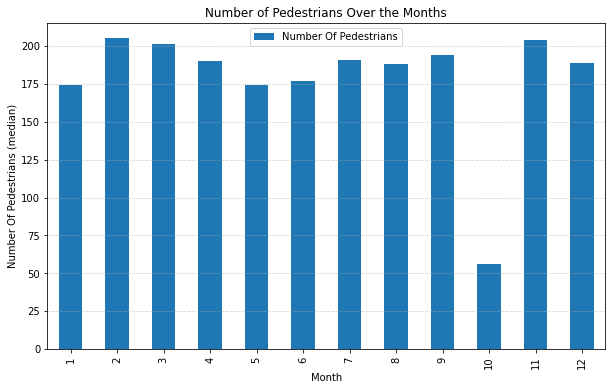

In [20]:
ax = df_ped_median_m.plot(kind='bar', y='Total_of_Directions', figsize=(10, 6))

ax.set_title('Number of Pedestrians Over the Months')
ax.set_xlabel('Month')
ax.set_ylabel('Number Of Pedestrians (median)')
ax.legend(['Number Of Pedestrians'])
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

## Preparing Data For ML

Dropping columns that wont be needed for ML, and convering the hour column from time objects into integers for ML use.

In [21]:
df_ml = df_merged.drop(columns=['LocationID','Direction_1','Direction_2','Location','datetime'])

def get_hour(x):
    return x.hour

df_ml['Hour_Number'] = df_ml['hour'].apply(get_hour)
df_ml.drop(columns=['hour'], inplace=True)

In [22]:
print(df_ml.shape)
df_ml.head()

(490544, 7)


,Sensor_Name,Total_of_Directions,temperature,humidity,day_of_week,month,Hour_Number
0,261Will_T,342,17.006667,73.813333,2,6,6
1,261Will_T,774,17.393333,72.800000,2,6,7
2,261Will_T,1200,17.847500,73.305000,2,6,9
3,261Will_T,557,18.130000,73.372500,2,6,11
4,261Will_T,674,20.505000,65.530000,2,6,15


## Single Sensor ML Preparation

Creating a dropdown menu to specify a specific sensor for ML prediction

In [23]:
dropdown_sensor = widgets.Dropdown(
    options=df_merged['Sensor_Name'].unique(), 
    value='Fra118_T',
    description='Sensor:',
    disabled=False,
)

display(dropdown_sensor)

Dropdown(description='Sensor:', index=34, options=('261Will_T', '280Will_T', '488Mac_T', '574Qub_T', 'ACMI_T',…

Filtering the dataframe to include only that specific sensor.

In [24]:
df_filtered = df_ml[df_ml['Sensor_Name'] == dropdown_sensor.value]
df_filtered = df_filtered.drop(columns=['Sensor_Name'])
df_filtered = df_filtered.dropna()

In [25]:
print(df_filtered.shape)
df_filtered.head()

(6815, 6)


,Total_of_Directions,temperature,humidity,day_of_week,month,Hour_Number
233379,5,16.736667,73.400000,2,6,3
233380,12,15.437500,77.325000,2,6,4
233381,32,17.006667,73.813333,2,6,6
233382,230,18.130000,73.372500,2,6,11
233383,292,18.923333,68.420000,2,6,12


Splitting features and target, creating train and testing sets.

In [26]:
features = df_filtered.drop("Total_of_Directions", axis=1)
target = df_filtered["Total_of_Directions"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## Model Training and Testing

Defining a function to measure model performance.

In [27]:
def performance(model):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    r2 = r2_score(y_test, predictions)

    print("Performance: ")
    print("MSE: " + str(mse))
    print("MAE: " + str(mae))
    print("RMSE: " + str(rmse))
    print("R2: " + str(r2))
    return predictions

Training and testing the performance of a gradient boosting regression model.

In [28]:
model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=0)
model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=500, random_state=0)

The performance is printed by the function, and a graph is created to show the difference between the actual and predicted values from the model, with the red line showing ideal predictions.

Performance: 
MSE: 1419.1017956881174
MAE: 24.18710097938196
RMSE: 37.670967543827665
R2: 0.8653779813821745


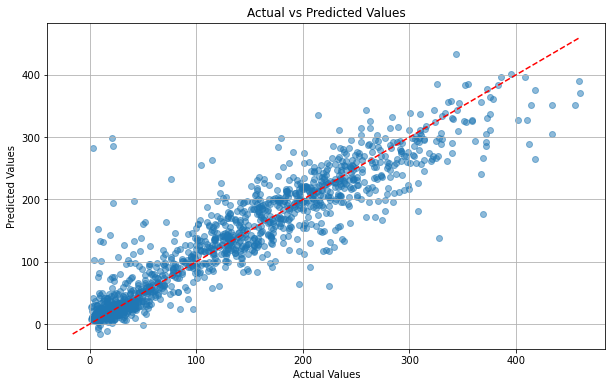

In [29]:
prediction = performance(model)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, prediction, alpha=0.5)

min_val = min(min(y_test), min(prediction))
max_val = max(max(y_test), max(prediction))
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red')

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

Next model tested is K-neighbours, with a simple method to determine a good K value. 

In [30]:
error_value = []

for k in range(1, 50):  
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    
    error = r2_score(y_test, predictions)
    error_value.append(error)

best_k = error_value.index(max(error_value)) + 1
print("The best k value is: " + str(best_k))

The best k value is: 5


In [31]:
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)

KNeighborsRegressor()

Performance: 
MSE: 2253.080029347029
MAE: 31.44534115920763
RMSE: 47.46662015929751
R2: 0.7862632669623741


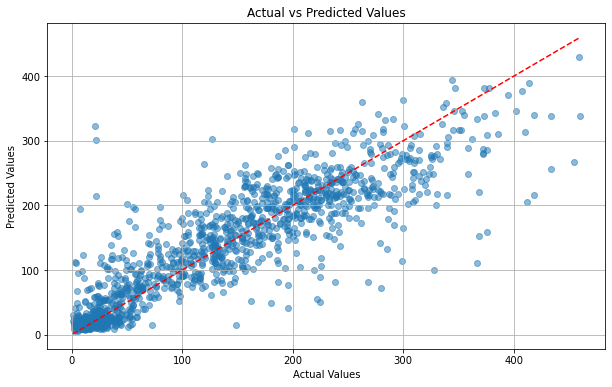

In [32]:
prediction = performance(model)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, prediction, alpha=0.5)

min_val = min(min(y_test), min(prediction))
max_val = max(max(y_test), max(prediction))
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red')

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

Finally, the random forest regression is also tested.

In [33]:
model = RandomForestRegressor(n_estimators = 200)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200)

Performance: 
MSE: 1245.358834922964
MAE: 22.505223771093178
RMSE: 35.289642034497376
R2: 0.8818599759578356


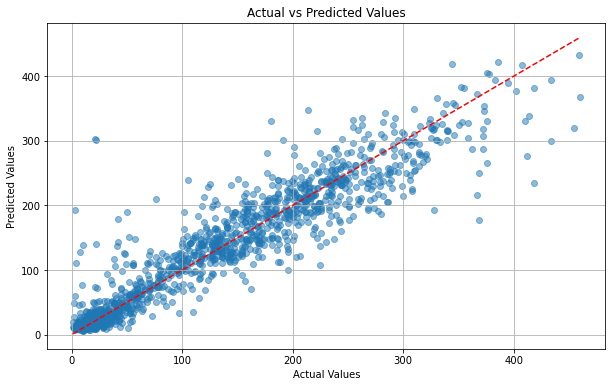

In [34]:
prediction = performance(model)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, prediction, alpha=0.5)

min_val = min(min(y_test), min(prediction))
max_val = max(max(y_test), max(prediction))
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red')

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

For custom variable inputs to the model, producing a single prediction.

In [35]:
temperature = 20
humidity = 60
month = 3
day = 2
hour = 12

df_input = {
    'temperature': [temperature],
    'humidity': [humidity],
    'day_of_week': [day],
    'month': [month],
    'Hour_Number': [hour]
}
single_prediction_df = pd.DataFrame(df_input)

In [36]:
prediction = model.predict(single_prediction_df)
print('predicted number of pedestrians:')
print(prediction[0])

predicted number of pedestrians:
290.43


## Preparing for composite/multiple model training

Creating a dataframe which includes a single row for each sensor, containing the maximum amount of people recorded at that sensor, along with its location, this will be used for creating a map later.

In [37]:
df_pos = df_merged.drop_duplicates(subset='Sensor_Name').copy()
df_pos.drop(columns=['LocationID','Direction_1','Direction_2','Total_of_Directions','datetime','temperature','humidity','hour','day_of_week','month'], inplace=True)
df_max = df_merged.groupby('Sensor_Name')['Total_of_Directions'].agg(max_people = 'max').reset_index()
df_loc_max = pd.merge(df_max, df_pos[['Sensor_Name', 'Location']], on='Sensor_Name', how='left')

In [38]:
df_loc_max.head()

,Sensor_Name,max_people,Location
0,261Will_T,2734,"-37.81295822, 144.95678789"
1,280Will_T,1023,"-37.81246271, 144.95690188"
2,488Mac_T,340,"-37.79432415, 144.92973378"
3,574Qub_T,241,"-37.80309992, 144.94908064"
4,ACMI_T,2869,"-37.81726338, 144.96872809"


This function takes a value, along with a maximum value. It scales the values so that max_val is 255 and val is proportionally scaled to fit this. 

RGB value starts with 0 in R, and 255 in G, meaning the resulting color would be pure green. Using the scaled value, we add this to R, and remove the same amount from G, so that the lower the value is, the greener it is, otherwise the higher it is (closer to max_val), the redder it becomes. It returns this color in a hexadecimal format for later use.

In [39]:
def color(val, max_val):
    target_max = 255
    scaling_factor = target_max / max_val
    scaled_val = int(val * scaling_factor)
    
    rgb = [0, 255, 0]
    rgb[0] = scaled_val
    rgb[1] = rgb[1] - scaled_val
    hexa = '#%02x%02x%02x' % tuple(rgb) 
    return hexa

## Training multiple models

Until this point, the models have been training on a specific sensors data. This is because the sensor is a categorical variable while its measurements are continuous. 

A different approach is needed in order to get predictions for each sensor and to be able to specify the sensor for which to predict to. The method below includes training a model for each sensor, and storing these models in a list, with the models index position corresponding to the sensor name it was trained on in another list. 

In [40]:
unique_sensors = df_loc_max['Sensor_Name'].values

In [41]:
models = []

for sensor in unique_sensors:
    df_filtered = df_ml[df_ml['Sensor_Name'] == sensor]
    df_filtered = df_filtered.drop(columns=['Sensor_Name'])
    df_filtered = df_filtered.dropna()
    
    features = df_filtered.drop("Total_of_Directions", axis=1)
    target = df_filtered["Total_of_Directions"]

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    
    model_s = RandomForestRegressor(n_estimators = 100)
    model_s.fit(X_train, y_train)
    
    models.append(model_s)

Now, after the models have all been trained, the results can be visualised in the map below, where the user can input their specificed variables for time and weather, to visualise approximated pedestrian traffic in those conditions at each sensor.

In [42]:
temperature = 20
humidity = 60
month = 3
day = 2
hour = 17

df_input = {
    'temperature': [temperature],
    'humidity': [humidity],
    'day_of_week': [day],
    'month': [month],
    'Hour_Number': [hour]
}
single_prediction_df = pd.DataFrame(df_input)

In [43]:
all_model_predictions = []

for i in range(len(models)):    
    prediction = models[i].predict(single_prediction_df)
    all_model_predictions.append(prediction[0])

In [44]:
df_single_models = df_loc_max.copy()
df_single_models['Prediction'] = all_model_predictions

In [45]:
df_single_models.head()

,Sensor_Name,max_people,Location,Prediction
0,261Will_T,2734,"-37.81295822, 144.95678789",1943.39
1,280Will_T,1023,"-37.81246271, 144.95690188",366.90
2,488Mac_T,340,"-37.79432415, 144.92973378",174.67
3,574Qub_T,241,"-37.80309992, 144.94908064",111.36
4,ACMI_T,2869,"-37.81726338, 144.96872809",1266.11


This creates the map using the above data, as well as the color function so that points with higher pedestrian traffic (compared to their recorded peaks) are redder, and points with less traffic are greener. 

In [46]:
m = folium.Map(location = [-37.80841815, 144.95906316], zoom_start = 14)

for index, row in df_single_models.iterrows():
    loc = row['Location']
    loc_list = [float(part.strip()) for part in loc.split(',')]
    
    folium.CircleMarker(
        location = loc_list,
        radius = 10, 
        popup = 'Predicted Number of Pedestrians: ' + str(int(row['Prediction'])),
        color = 'black',  
        fill = True,
        fill_color = color(row['Prediction'], row['max_people']),  
        fill_opacity = 1
    ).add_to(m)

m

## Training Composite Model

Another method for combining categorical and continuous data is by using a composite model. 

In [47]:
df_ml_comp = df_ml
print(df_ml_comp.shape)
df_ml_comp.head()

(490544, 7)


,Sensor_Name,Total_of_Directions,temperature,humidity,day_of_week,month,Hour_Number
0,261Will_T,342,17.006667,73.813333,2,6,6
1,261Will_T,774,17.393333,72.800000,2,6,7
2,261Will_T,1200,17.847500,73.305000,2,6,9
3,261Will_T,557,18.130000,73.372500,2,6,11
4,261Will_T,674,20.505000,65.530000,2,6,15


The features and target are split from the main ml dataframe, this time including the sensor name

In [48]:
features = df_ml_comp.drop("Total_of_Directions", axis=1)
target = df_ml_comp["Total_of_Directions"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

The sensor name is then encoded using an ordinal encoder, to turn it into numerical data. 

In [49]:
encoder = OrdinalEncoder()
X_train['Sensor_Name'] = encoder.fit_transform(X_train[['Sensor_Name']])
X_test['Sensor_Name'] = encoder.transform(X_test[['Sensor_Name']])

In [50]:
decoded_values = encoder.inverse_transform(X_train['Sensor_Name'].to_numpy().reshape(-1, 1))
encoded_values = X_train['Sensor_Name'].to_numpy().reshape(-1, 1)

The model is then trained using this entire dataset, which includes the sensor names as encoded numerical values.

In [51]:
model = RandomForestRegressor(n_estimators = 300)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300)

Performance: 
MSE: 29137.274243154607
MAE: 73.61912257455145
RMSE: 170.69643887074682
R2: 0.9269703009941642


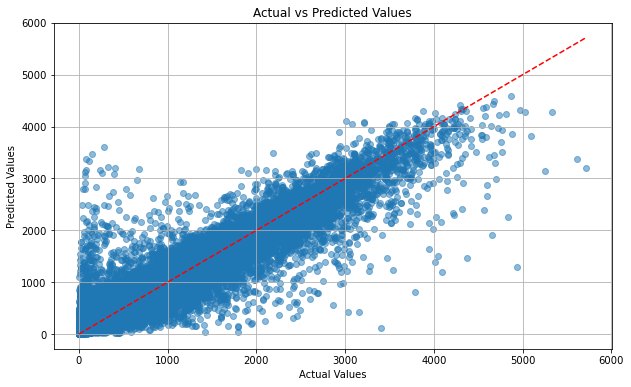

In [52]:
prediction = performance(model)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, prediction, alpha=0.5)

# Plot the perfect prediction line
min_val = min(min(y_test), min(prediction))
max_val = max(max(y_test), max(prediction))
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red')

# Labelling
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

## Mapping Composite Model

The decoded values are then used along with custom user inputs to generate predictions using the trained composite model

In [53]:
decoded_flat = decoded_values.flatten()
encoded_flat = encoded_values.flatten() 

coded_dict = dict(zip(decoded_flat, encoded_flat))

decoded = np.array(list(coded_dict.keys()))
encoded = np.array(list(coded_dict.values()))

In [54]:
df_input = pd.DataFrame(encoded, columns=['Sensor_Name'])

temperature = 20
humidity = 60
month = 3
day = 2
hour = 17

df_input['temperature'] = temperature
df_input['humidity'] = humidity
df_input['day_of_week'] = month
df_input['month'] = day
df_input['Hour_Number'] = hour

print(df_input.shape)
df_input.head()

(71, 6)


,Sensor_Name,temperature,humidity,day_of_week,month,Hour_Number
0,4.0,20,60,3,2,17
1,6.0,20,60,3,2,17
2,33.0,20,60,3,2,17
3,19.0,20,60,3,2,17
4,67.0,20,60,3,2,17


In [55]:
prediction_composite = model.predict(df_input)
df_output = pd.DataFrame(decoded, columns=['Sensor_Name'])
df_output['Prediction'] = prediction_composite
df_composite_model = pd.merge(df_output, df_loc_max[['Sensor_Name', 'Location', 'max_people']], on='Sensor_Name', how='left')

In [56]:
df_composite_model.head()

,Sensor_Name,Prediction,Location,max_people
0,ACMI_T,1270.946667,"-37.81726338, 144.96872809",2869
1,AlfPl_T,333.110000,"-37.81379749, 144.96995745",890
2,FliS_T,2500.403333,"-37.81911705, 144.96558255",4515
3,Eli250_T,2250.713333,"-37.81160332, 144.96220077",3047
4,Vic_T,251.920000,"-37.80606888, 144.95644692",787


The dataframe including these predictions is then mapped out using folium. 

The results will differ between using multiple models, each being trained on a single sensor (like done above) and a composite model which trains using the whole dataset. The composite model will generally have smoother overall predictions, reducing noise, while the other method will be able to create better predictions for sensors which have patterns that heavily deviate from the rest.

In [57]:
m = folium.Map(location = [-37.80841815, 144.95906316], zoom_start=14)

for index, row in df_composite_model.iterrows():
    loc = row['Location']
    loc_list = [float(part.strip()) for part in loc.split(',')]
    
    folium.CircleMarker(
        location = loc_list,
        radius = 10, 
        popup = 'Predicted Number of Pedestrians: ' + str(int(row['Prediction'])),
        color = 'black',  
        fill = True,
        fill_color = color(row['Prediction'], row['max_people']),  
        fill_opacity = 1
    ).add_to(m)

m